<font size="+3"><strong> Gradient Boosting Trees</strong></font>

You've been working hard, and now you have all the tools you need to build and tune  models. We'll start this lesson the same way we've started the others: preparing the data and building our model, and this time with a new ensemble model. Once it's working, we'll learn some new performance metrics to evaluate it. By the end of this lesson, you'll have written your first Python module!  

In [25]:
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from teaching_tools.widgets import ConfusionMatrixWidget

# Prepare Data

## Import

**Task 5.4.1:** Complete the `wrangle` function below using the code you developed in the  lesson 5.1. Then use it to import `poland-bankruptcy-data-2009.json.gz` into the DataFrame `df`.


In [4]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename,"r") as f:
        data = json.load(f)
    # Load dictionary into DataFrame, set index
    df=pd.DataFrame.from_dict(data["data"]).set_index("company_id")
    return df

In [5]:
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,Attr_1,Attr_2,Attr_3,Attr_4,Attr_5,Attr_6,Attr_7,Attr_8,Attr_9,Attr_10,...,Attr_56,Attr_57,Attr_58,Attr_59,Attr_60,Attr_61,Attr_62,Attr_63,Attr_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
4,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False


## Split

**Task 5.4.2:** Create your feature matrix `X` and target vector `y`. Your target is `"bankrupt"`. 


In [6]:
target = "bankrupt"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


**Task 5.4.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2 , random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


## Resample

**Task 5.4.4:** Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data.


In [8]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (15194, 64)


,Attr_1,Attr_2,Attr_3,Attr_4,Attr_5,Attr_6,Attr_7,Attr_8,Attr_9,Attr_10,...,Attr_55,Attr_56,Attr_57,Attr_58,Attr_59,Attr_60,Attr_61,Attr_62,Attr_63,Attr_64
0,0.121230,0.84119,0.156800,1.18900,25.4150,0.00000,0.149930,0.18879,2.36040,0.15881,...,2519.90,0.062611,0.763360,0.93666,0.000000,NaN,2.4956,128.260,2.8458,171.6300
1,0.009168,1.23540,-0.659060,0.22347,-143.1000,-0.57453,0.009168,-0.19052,1.75080,-0.23536,...,-199.71,-0.007404,-0.038951,0.99507,-1.603800,95.4700,10.5420,176.940,2.0628,2.1605
2,0.041290,0.32144,0.115610,1.38590,-64.4780,0.23585,0.041290,2.10300,1.07380,0.67599,...,1851.80,0.068742,0.061081,0.93126,0.032312,4.0947,16.1260,122.120,2.9889,1.5312
3,0.078780,0.39680,0.013543,1.05890,5.6338,0.00000,0.078780,1.52020,0.87894,0.60320,...,105.45,0.111240,0.130600,0.91263,0.276570,4435.2000,4.0019,95.499,3.8220,1.1619
4,0.061946,0.44483,0.108770,1.39480,40.3740,0.00000,0.078467,1.24810,1.08370,0.55517,...,305.28,0.083842,0.111580,0.92843,0.305000,548.4500,3.1107,92.786,3.9338,1.7601


# Build Model

Now let's put together our model. We'll start by calculating the baseline accuracy, just like we did last time.

## Baseline

**Task 5.4.5:** Calculate the baseline accuracy score for your model.


In [9]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## Iterate

Even though the building blocks are the same, here's where we start working with something new. First, we're going to use a new type of ensemble model for our classifier. 

**Task 5.4.6:** Create a pipeline named `clf` (short for "classifier") that contains a `SimpleImputer` transformer and a `GradientBoostingClassifier` predictor.


In [10]:
clf = make_pipeline(SimpleImputer(),GradientBoostingClassifier())

Remember while we're doing this that we only want to be looking at the *positive* class. Here, the positive class is the one where the companies really did go bankrupt. In the dictionary we made last time, the positive class is made up of the companies with the `bankrupt: true` key-value pair.

Next, we're going to tune some of the hyperparameters for our model.

**Task 5.4.7:** Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier. 

1. For the `SimpleImputer`, try both the `"mean"` and `"median"` strategies. 
2. For the `GradientBoostingClassifier`, try `max_depth` settings between 2 and 5. 
3. Also for the `GradientBoostingClassifier`, try `n_estimators` settings between 20 and 31, by steps of 5.

In [11]:
params = {
    "simpleimputer__strategy":["mean","median"],
    "gradientboostingclassifier__n_estimators":range(20,31,5),
    "gradientboostingclassifier__max_depth":range(2,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

Note that we're trying much smaller numbers of `n_estimators`. This is because `GradientBoostingClassifier` is slower to train than the `RandomForestClassifier`. You can try increasing the number of estimators to see if model performance improves, but keep in mind that you could be waiting a long time!

**Task 5.4.8:** Create a `GridSearchCV` named `model` that includes your classifier and hyperparameter grid. Be sure to use the same arguments for `cv` and `n_jobs` that you used above, and set `verbose` to 1. 


In [12]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

**Task 5.4.9:** Fit your `model` to the over-sampled training data.

In [13]:
# Fit model to over-sampled training data
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

**Task 5.4.10:** Extract the cross-validation results from `model` and load them into a DataFrame named `cv_results`.

- Get cross-validation results from a hyperparameter search in scikit-learn.

In [15]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,13.728664,0.291767,0.013763,0.001716,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.918723,0.917736,0.905561,0.908852,0.905201,0.911215,0.005876,1
14,10.741856,0.252729,0.012367,0.001017,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.908523,0.908193,0.899967,0.899638,0.894997,0.902264,0.005279,2
17,12.804138,1.242345,0.011576,0.002319,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.900296,0.906877,0.897335,0.897006,0.900592,0.900421,0.003547,3
15,10.879488,0.101163,0.012766,0.000746,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.890424,0.897993,0.885160,0.886476,0.892693,0.890549,0.004597,4
12,8.385960,0.035662,0.011786,0.000409,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.897006,0.896347,0.886147,0.883185,0.885780,0.889693,0.005796,5


**Task 5.4.11:** Extract the best hyperparameters from `model`.


In [16]:
# Extract best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

## Evaluate

Now that we have a working model that's actually giving us something useful, let's see how good it really is.

**Task 5.4.12:** Calculate the training and test accuracy scores for `model`. 


In [17]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)
print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9054
Validation Accuracy: 0.8768


**Task 5.4.13:** Plot a confusion matrix that shows how your best model performs on your test set. 


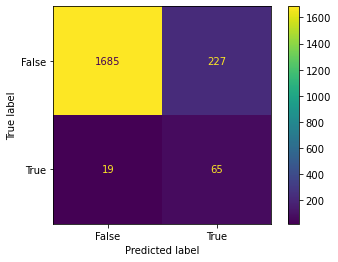

In [18]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

This matrix is a great reminder of how imbalanced our data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. After all, if 95% of the companies in our dataset didn't go bankrupt, all the model has to do is always predict `{"bankrupt": False}`, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

Instead, we can evaluate our model using two new metrics: **precision** and **recall**.  The precision score is important when we want our model to only predict that a company will go bankrupt if its very confident in its prediction. The *recall* score is important if we want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes. 

Let's start with a report you can create with scikit-learn to calculate both metrics. Then we'll look at them one-by-one using a visualization tool we've built especially for the Data Science Lab.

**Task 5.4.14:** Print the classification report for your model, using the test set.


In [19]:
# Print classification report
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1912
        True       0.22      0.77      0.35        84

    accuracy                           0.88      1996
   macro avg       0.61      0.83      0.64      1996
weighted avg       0.96      0.88      0.91      1996



**Task 5.4.15:** Run the cell below to load the confusion matrix widget.


In [26]:
c = ConfusionMatrixWidget(model, X_test, y_test)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

If you move the probability threshold, you can see that there's a tradeoff between precision and recall. That is, as one gets better, the other suffers. As a data scientist, you'll often need to decide whether you want a model with better precision or better recall. What you choose will depend on how to intend to use your model.

Let's look at two examples, one where recall is the priority and one where precision is more important. First, let's say you work for a regulatory agency in the European Union that assists companies and investors navigate [insolvency proceedings](https://en.wikipedia.org/wiki/Insolvency_Regulation). You want to build a model to predict which companies could go bankrupt so that you can send debtors information about filing for legal protection before their company becomes insolvent. The administrative costs of sending information to a company is €500. The legal costs to the European court system if a company doesn't file for protection before bankruptcy is €50,000.

For a model like this, we want to focus on **recall**, because recall is all about *quantity*. A model that prioritizes recall will cast the widest possible net, which is the way to approach this problem. We want to send information to as many potentially-bankrupt companies as possible, because it costs a lot less to send information to a company that might not become insolvent than it does to skip a company that does. 

**Task 5.4.16:** Run the cell below, and use the slider to change the probability threshold of your model. What relationship do you see between changes in the threshold and changes in wasted administrative and legal costs? In your opinion, which is more important for this model: high precision or high recall?

In [27]:
c.show_eu()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

For the second example, let's say we work at a private equity firm that purchases distressed businesses, improve them, and then sells them for a profit. You want to build a model to predict which companies will go bankrupt so that you can purchase them ahead of your competitors. If the firm purchases a company that is indeed insolvent, it can make a profit of €100 million or more. But if it purchases a company that isn't insolvent and can't be resold at a profit, the firm will lose €250 million. 

For a model like this, we want to focus on **precision**. If we're trying to maximize our profit, the *quality* of our predictions is much more important than the *quantity* of our predictions. It's not a big deal if we don't catch every single insolvent company, but it's *definitely* a big deal if the companies we catch don't end up becoming insolvent.

This time we're going to build the visualization together. 

**Task 5.4.17:** Create an interactive dashboard that shows how company profit and losses change in relationship to your model's probability threshold. Start with the `make_cnf_matrix` function, which should calculate and print profit/losses, and display a confusion matrix. Then create a FloatSlider `thresh_widget` that ranges from 0 to 1. Finally combine your function and slider in the `interact` function.

In [29]:
threshold = 0.5
y_pred_proba = model.predict_proba(X_test)[:,-1]
y_pred = y_pred_proba>threshold
conf_matrix = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print(f"profit: €{tp*100_00_00}")
print(f"losses: €{fp*250_00_00}")

profit: €65000000
losses: €567500000


In [30]:
def make_cnf_matrix(threshold):
    
    y_pred_proba = model.predict_proba(X_test)[:,-1]
    y_pred = y_pred_proba>threshold
    conf_matrix = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"profit: €{tp*100_00_00}")
    print(f"losses: €{fp*250_00_00}")


thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

# Communicate

Almost there! Save the best model so we can share it with other people, then put it all together with what we learned in the last lesson.

**Task 5.4.18:** Using a context manager, save your best-performing model to a file named `"model-5-4.pkl"`. 


In [31]:
# Save model
with open("model-5-4.pkl","wb") as f :
    pickle.dump(model.best_estimator_,f)

**Task 5.4.19:** Open the file `my_predictor_lesson.py`, add the `wrangle` and `make_predictions` functions from the last lesson, and add all the necessary import statements to the top of the file. Once you're done, save the file. You can check that the contents are correct by running the cell below. 


In [47]:
# %%bash

# cat my_predictor_lesson.py

In [42]:
with open('my_predictor_lesson.py', 'r') as file:
    contents = file.read()
    print(contents)

# Import libraries
import gzip
import json
import pickle

import pandas as pd


# Add wrangle function from lesson 5.4
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename,"r") as f:
        data = json.load(f)
    # Load dictionary into DataFrame, set index
    df=pd.DataFrame.from_dict(data["data"]).set_index("company_id")
    return df


# Add make_predictions function from lesson 5.3
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open (model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred



**Task 5.4.20:** Import your `make_predictions` function from your `my_predictor` module, and use the code below to make sure it works as expected. Once you're satisfied, submit it to the grader.  

In [48]:
# Import your module
from my_predictor_lesson import make_predictions

# Generate predictions
y_test_pred = make_predictions(
    data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="model-5-4.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
9     False
28    False
40     True
81    False
83    False
Name: bankrupt, dtype: bool